In [3]:
# Uploading the MicrobeAtlas database
import glob
import h5py
from scipy.sparse import csc_matrix

# Data manipulation
import numpy as np
import pandas as pd
from ete3 import Tree

from scipy.stats import mannwhitneyu, wilcoxon

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# Mapping between all specI clusters to OTUs.
speci_to_otu_mapping = pd.read_csv("mapping_progenomes_v2.2_speci_clusters_to_mapref_v2.2b_OTUs.tsv", sep = "\t")

# These are clusters that are not taxonomically coherent according to GTDB.
problematic_clusters = ["specI_v3_Cluster22", "specI_v3_Cluster2375", "specI_v3_Cluster4851", "specI_v3_Cluster5010", "specI_v3_Cluster5514"]

# To select OTUs for further analysis, we only consider specI clusters that went into the pipeline.
speci_clusters_in_pipeline = Tree("species_tree_progenomes_v2.2_no_chimera_reps_only_mapping_to_otus.nwk").get_leaf_names()
speci_clusters_in_pipeline = ["specI_v3_" + x for x in speci_clusters_in_pipeline]
speci_clusters_in_pipeline = [x for x in speci_clusters_in_pipeline if x not in problematic_clusters]

# Now, selecting the OTUs that map to the corresponding specI clusters.
otus_in_pipeline = speci_to_otu_mapping.loc[(speci_to_otu_mapping["speci_id"].isin(speci_clusters_in_pipeline)) & (speci_to_otu_mapping["OTU97"] != "unmapped"), "OTU97"].unique()

# In MAPdb table, otus are written in short format - only the 97% identifier is present.
otus_in_pipeline_short = [x[0] + x.split(";")[-1] for x in otus_in_pipeline]

### Calculating sample overlaps for all OTUs considered in the analysis

In [3]:
# Function for importing sample data and metadata.
def read_mapdb_h5(h5_path, otu_data=True, meta_data=True):
    f = h5py.File(h5_path, 'r')
    result_dict = {}
    # read otu data
    if otu_data:
        data_handle = f["otu_table"]
        col_ptr, nzvals, rowindices, otu_index, sample_index = [np.array(data_handle[sub_key]) for sub_key in ['data_colptr', 'data_nzval', 'data_rowval', 'oids', 'sids']]
        ## correct indexing (julia starts at 1)
        col_ptr -= 1
        rowindices -= 1
        otutable_sparse = csc_matrix((nzvals,rowindices,col_ptr), shape=(data_handle["m"][()],data_handle["n"][()]))
        result_dict["otu_data"] = {"otu_table": otutable_sparse, "otu_index": otu_index, "sample_index": sample_index}
    # read meta data
    if meta_data:
        meta_handle = f["meta_data"]
        result_dict["meta_data"] = {sub_key: pd.DataFrame(np.array(meta_handle[sub_key]).T) for sub_key in meta_handle.keys()}
    f.close()
    return result_dict

mapdb_complete = read_mapdb_h5("/mnt/mnemo3/janko/data/microbe_atlas/hdf5/v0.2.2/metag_minfilter/samples-otus.97.metag.minfilter.remap.minCov90.noMulticell.h5")

In [4]:
# Converting sample ids and OTU ids to strings.
convert_to_string = np.vectorize(lambda x: x.decode("utf-8"))
mapdb_complete["otu_data"]["otu_index"] = convert_to_string(mapdb_complete["otu_data"]["otu_index"])
mapdb_complete["otu_data"]["sample_index"] = convert_to_string(mapdb_complete["otu_data"]["sample_index"])

In [5]:
# Calculating the total number of reads in the sample.
total_reads = mapdb_complete["otu_data"]["otu_table"].sum(axis = 1)

# Only selecting rows in table that correspond to the OTUs we consider for the analysis.
selected_otus = np.isin(mapdb_complete["otu_data"]["otu_index"], otus_in_pipeline_short)
otu_table_selected = mapdb_complete["otu_data"]["otu_table"][:, selected_otus]
print(otu_table_selected.shape)

# We calculate the relative abundances for each OTU.
otu_table_rel_abundance = csc_matrix(otu_table_selected / total_reads)

# Presence is noted if relative abundance is more than 1 in 10'000.
otu_table_presence = csc_matrix(otu_table_rel_abundance > 0.0001, dtype = "int32")
otu_table_presence.to_csv("presence_of_studied_OTUs_across_microbe_atlas_database.csv", sep = ",", index = False)

(1039362, 4380)


In [6]:
# Generating pairwise combinations of all OTUs considered.
all_otu_combinations = []
for otu_1 in range(len(otus_in_pipeline_short)-1):
    for otu_2 in range(otu_1+1, len(otus_in_pipeline_short)):
        all_otu_combinations.append([otus_in_pipeline_short[otu_1], otus_in_pipeline_short[otu_2]])
print(all_otu_combinations[:10])

[['B97_49', 'B97_970'], ['B97_49', 'B97_7'], ['B97_49', 'B97_4466'], ['B97_49', 'B97_2269'], ['B97_49', 'B97_1518'], ['B97_49', 'B97_30905'], ['B97_49', 'B97_2352'], ['B97_49', 'B97_2153'], ['B97_49', 'B97_782'], ['B97_49', 'B97_553']]


In [33]:
# For each OTU, counting the number of samples it's present in.
otus_in_mapdb_table = mapdb_complete["otu_data"]["otu_index"][selected_otus]
otus_number_samples = [otu_table_presence[:,i].nnz for i in range(len(otus_in_mapdb_table))]

# For each OTU pair, counting number of intersecting samples.
sample_intersections = []
for i in range(len(all_otu_combinations)):
    
    otu_1 = all_otu_combinations[i][0]
    otu_2 = all_otu_combinations[i][1]

    if otu_1 in otus_in_mapdb_table and otu_2 in otus_in_mapdb_table:
        sum_two_arrays = otu_table_presence[:,np.where(otus_in_mapdb_table == otu_1)[0]] + otu_table_presence[:,np.where(otus_in_mapdb_table == otu_2)[0]]
        intersection = (sum_two_arrays == 2).nnz
        sample_intersections.append(intersection)
    else:
        sample_intersections.append(np.nan)
    
    if i % 100000 == 0:
        print("{}\t{} / {}".format(datetime.now().time().strftime("%H:%M:%S"), i, len(all_otu_combinations)))       

14:16:19.610652	0 / 9603153
14:16:26.200645	10000 / 9603153
14:16:33.904440	20000 / 9603153
14:16:40.390909	30000 / 9603153
14:16:46.788131	40000 / 9603153
14:16:53.804746	50000 / 9603153
14:17:00.001370	60000 / 9603153
14:17:06.602595	70000 / 9603153
14:17:13.391197	80000 / 9603153
14:17:19.452083	90000 / 9603153
14:17:26.117808	100000 / 9603153
14:17:33.528829	110000 / 9603153
14:17:40.075844	120000 / 9603153
14:17:46.380931	130000 / 9603153
14:17:52.569993	140000 / 9603153
14:17:59.405026	150000 / 9603153
14:18:05.554832	160000 / 9603153
14:18:11.902939	170000 / 9603153
14:18:19.553596	180000 / 9603153
14:18:26.256255	190000 / 9603153
14:18:32.227362	200000 / 9603153
14:18:38.783953	210000 / 9603153
14:18:44.818397	220000 / 9603153
14:18:50.947659	230000 / 9603153
14:18:57.172750	240000 / 9603153
14:19:03.438206	250000 / 9603153
14:19:10.232570	260000 / 9603153
14:19:16.302558	270000 / 9603153
14:19:22.540505	280000 / 9603153
14:19:28.769149	290000 / 9603153
14:19:36.436912	300000 /

14:42:25.601864	2450000 / 9603153
14:42:31.476075	2460000 / 9603153
14:42:37.486715	2470000 / 9603153
14:42:43.423116	2480000 / 9603153
14:42:49.411080	2490000 / 9603153
14:42:55.416559	2500000 / 9603153
14:43:01.549542	2510000 / 9603153
14:43:07.745861	2520000 / 9603153
14:43:13.727110	2530000 / 9603153
14:43:19.910807	2540000 / 9603153
14:43:26.163599	2550000 / 9603153
14:43:32.073152	2560000 / 9603153
14:43:37.961225	2570000 / 9603153
14:43:44.669855	2580000 / 9603153
14:43:50.760208	2590000 / 9603153
14:43:57.150971	2600000 / 9603153
14:44:04.276990	2610000 / 9603153
14:44:10.398072	2620000 / 9603153
14:44:16.438197	2630000 / 9603153
14:44:22.991522	2640000 / 9603153
14:44:29.346521	2650000 / 9603153
14:44:35.513038	2660000 / 9603153
14:44:41.545839	2670000 / 9603153
14:44:47.824651	2680000 / 9603153
14:44:54.736779	2690000 / 9603153
14:45:01.688417	2700000 / 9603153
14:45:07.556019	2710000 / 9603153
14:45:13.989711	2720000 / 9603153
14:45:20.862536	2730000 / 9603153
14:45:26.82052

15:07:35.858037	4860000 / 9603153
15:07:42.177197	4870000 / 9603153
15:07:48.322826	4880000 / 9603153
15:07:54.905714	4890000 / 9603153
15:08:01.323910	4900000 / 9603153
15:08:07.391413	4910000 / 9603153
15:08:13.506862	4920000 / 9603153
15:08:19.743952	4930000 / 9603153
15:08:25.883043	4940000 / 9603153
15:08:32.349895	4950000 / 9603153
15:08:38.098764	4960000 / 9603153
15:08:44.577622	4970000 / 9603153
15:08:50.798264	4980000 / 9603153
15:08:56.769191	4990000 / 9603153
15:09:03.176112	5000000 / 9603153
15:09:09.302767	5010000 / 9603153
15:09:15.202945	5020000 / 9603153
15:09:21.403196	5030000 / 9603153
15:09:27.619394	5040000 / 9603153
15:09:33.780168	5050000 / 9603153
15:09:40.068115	5060000 / 9603153
15:09:46.410463	5070000 / 9603153
15:09:52.529092	5080000 / 9603153
15:09:59.162560	5090000 / 9603153
15:10:06.065961	5100000 / 9603153
15:10:12.139378	5110000 / 9603153
15:10:18.040549	5120000 / 9603153
15:10:24.213719	5130000 / 9603153
15:10:30.508818	5140000 / 9603153
15:10:36.61784

15:33:34.493740	7270000 / 9603153
15:33:40.099081	7280000 / 9603153
15:33:46.602818	7290000 / 9603153
15:33:52.976135	7300000 / 9603153
15:34:00.875557	7310000 / 9603153
15:34:08.833248	7320000 / 9603153
15:34:15.061766	7330000 / 9603153
15:34:21.287668	7340000 / 9603153
15:34:28.951066	7350000 / 9603153
15:34:37.272258	7360000 / 9603153
15:34:43.892689	7370000 / 9603153
15:34:50.288035	7380000 / 9603153
15:34:56.602888	7390000 / 9603153
15:35:02.878463	7400000 / 9603153
15:35:09.665875	7410000 / 9603153
15:35:16.013256	7420000 / 9603153
15:35:22.930537	7430000 / 9603153
15:35:30.332465	7440000 / 9603153
15:35:37.683495	7450000 / 9603153
15:35:44.564268	7460000 / 9603153
15:35:52.637080	7470000 / 9603153
15:36:00.282637	7480000 / 9603153
15:36:07.151221	7490000 / 9603153
15:36:14.329889	7500000 / 9603153
15:36:21.733926	7510000 / 9603153
15:36:29.190970	7520000 / 9603153
15:36:37.077660	7530000 / 9603153
15:36:45.285483	7540000 / 9603153
15:36:52.599685	7550000 / 9603153
15:36:59.29199

In [39]:
# Generating table where we will put information on prevalence of both OTUs and intersecting samples.
results_table_all = pd.DataFrame({"otu_1": [x[0] for x in all_otu_combinations],
                                  "otu_2": [x[1] for x in all_otu_combinations],
                                  "event_id": [" ".join(x) for x in all_otu_combinations],
                                  "intersection": sample_intersections})
# Adding information on presence.
otus_number_samples_series = pd.Series(otus_number_samples)
otus_number_samples_series.index = mapdb_complete["otu_data"]["otu_index"][selected_otus]
results_table_all["presence_1"] = results_table_all["otu_1"].map(otus_number_samples_series)
results_table_all["presence_2"] = results_table_all["otu_2"].map(otus_number_samples_series)

# Calculating the fraction of overlaping samples based on less prevalent OTU in pair.
results_table_all["minimum_overlap"] = np.minimum(results_table_all["presence_1"], results_table_all["presence_2"])
results_table_all["fraction_overlap"] = results_table_all["intersection"] / results_table_all["minimum_overlap"]
results_table_all.head()

,otu_1,otu_2,event_id,intersection,presence_1,presence_2,minimum_overlap,fraction_overlap
0,B97_49,B97_970,B97_49 B97_970,7.0,433.0,1547.0,433.0,0.016166
1,B97_49,B97_7,B97_49 B97_7,130.0,433.0,129069.0,433.0,0.300231
2,B97_49,B97_4466,B97_49 B97_4466,4.0,433.0,1974.0,433.0,0.009238
3,B97_49,B97_2269,B97_49 B97_2269,8.0,433.0,9155.0,433.0,0.018476
4,B97_49,B97_1518,B97_49 B97_1518,1.0,433.0,8039.0,433.0,0.002309


In [55]:
# Now that we have all the overlap data, we return the long OTU names to map transfer table.
map_short_to_long_otu_names = pd.Series(otus_in_pipeline)
map_short_to_long_otu_names.index = otus_in_pipeline_short

results_table_all["otu97_1"] = results_table_all["otu_1"].map(map_short_to_long_otu_names)
results_table_all["otu97_2"] = results_table_all["otu_2"].map(map_short_to_long_otu_names)
results_table_all["event_id"] = results_table_all["otu97_1"] + " " + results_table_all["otu97_2"]
results_table_all.head()

,otu_1,otu_2,event_id,intersection,presence_1,presence_2,minimum_overlap,fraction_overlap,otu97_1,otu97_2
0,B97_49,B97_970,B16S;90_34;96_47;97_49 B16S;90_113;96_838;97_970,7.0,433.0,1547.0,433.0,0.016166,B16S;90_34;96_47;97_49,B16S;90_113;96_838;97_970
1,B97_49,B97_7,B16S;90_34;96_47;97_49 B16S;90_7;96_7;97_7,130.0,433.0,129069.0,433.0,0.300231,B16S;90_34;96_47;97_49,B16S;90_7;96_7;97_7
2,B97_49,B97_4466,B16S;90_34;96_47;97_49 B16S;90_45;96_3683;97_4466,4.0,433.0,1974.0,433.0,0.009238,B16S;90_34;96_47;97_49,B16S;90_45;96_3683;97_4466
3,B97_49,B97_2269,B16S;90_34;96_47;97_49 B16S;90_255;96_1901;97_...,8.0,433.0,9155.0,433.0,0.018476,B16S;90_34;96_47;97_49,B16S;90_255;96_1901;97_2269
4,B97_49,B97_1518,B16S;90_34;96_47;97_49 B16S;90_531;96_1300;97_...,1.0,433.0,8039.0,433.0,0.002309,B16S;90_34;96_47;97_49,B16S;90_531;96_1300;97_1518


### Adding information on the number of genes transferred.

In [68]:
genes_transferred = pd.read_csv("aggregated_transfers_gene_distance_0.00_100.00_support_0.50.csv")
genes_transferred_map = genes_transferred["genes_transferred"]
genes_transferred_map.index = genes_transferred["otu_1"] + " " + genes_transferred["otu_2"]

results_table_all["genes_transferred"] = results_table_all["event_id"].map(genes_transferred_map)
results_table_all.loc[results_table_all["genes_transferred"].isna(), "genes_transferred"] = 0
results_table_all.head()

,otu_1,otu_2,event_id,intersection,presence_1,presence_2,minimum_overlap,fraction_overlap,otu97_1,otu97_2,genes_transferred,distance
0,B97_49,B97_970,B16S;90_34;96_47;97_49 B16S;90_113;96_838;97_970,7.0,433.0,1547.0,433.0,0.016166,B16S;90_34;96_47;97_49,B16S;90_113;96_838;97_970,0.0,1.1319
1,B97_49,B97_7,B16S;90_34;96_47;97_49 B16S;90_7;96_7;97_7,130.0,433.0,129069.0,433.0,0.300231,B16S;90_34;96_47;97_49,B16S;90_7;96_7;97_7,1.0,0.8813
2,B97_49,B97_4466,B16S;90_34;96_47;97_49 B16S;90_45;96_3683;97_4466,4.0,433.0,1974.0,433.0,0.009238,B16S;90_34;96_47;97_49,B16S;90_45;96_3683;97_4466,0.0,0.8332
3,B97_49,B97_2269,B16S;90_34;96_47;97_49 B16S;90_255;96_1901;97_...,8.0,433.0,9155.0,433.0,0.018476,B16S;90_34;96_47;97_49,B16S;90_255;96_1901;97_2269,0.0,0.7954
4,B97_49,B97_1518,B16S;90_34;96_47;97_49 B16S;90_531;96_1300;97_...,1.0,433.0,8039.0,433.0,0.002309,B16S;90_34;96_47;97_49,B16S;90_531;96_1300;97_1518,0.0,0.6651


### Adding information on the phylogenetic distance and saving table to file.

In [61]:
phylogenetic_distances_1 = pd.read_csv("phylogenetic_distances_between_otus.csv")
phylogenetic_distances_2 = phylogenetic_distances_1.loc[:, ["species_2", "species_1", "distance"]]
phylogenetic_distances_2.columns = phylogenetic_distances_1.columns
phylogenetic_distances = pd.concat([phylogenetic_distances_1, phylogenetic_distances_2])
phylogenetic_distances_map = phylogenetic_distances["distance"]
phylogenetic_distances_map.index = phylogenetic_distances["species_1"] + " " + phylogenetic_distances["species_2"]
results_table_all["distance"] = results_table_all["event_id"].map(phylogenetic_distances_map)
results_table_all.head()

,otu_1,otu_2,event_id,intersection,presence_1,presence_2,minimum_overlap,fraction_overlap,otu97_1,otu97_2,genes_transferred,distance
0,B97_49,B97_970,B16S;90_34;96_47;97_49 B16S;90_113;96_838;97_970,7.0,433.0,1547.0,433.0,0.016166,B16S;90_34;96_47;97_49,B16S;90_113;96_838;97_970,0.0,1.1319
1,B97_49,B97_7,B16S;90_34;96_47;97_49 B16S;90_7;96_7;97_7,130.0,433.0,129069.0,433.0,0.300231,B16S;90_34;96_47;97_49,B16S;90_7;96_7;97_7,1.0,0.8813
2,B97_49,B97_4466,B16S;90_34;96_47;97_49 B16S;90_45;96_3683;97_4466,4.0,433.0,1974.0,433.0,0.009238,B16S;90_34;96_47;97_49,B16S;90_45;96_3683;97_4466,0.0,0.8332
3,B97_49,B97_2269,B16S;90_34;96_47;97_49 B16S;90_255;96_1901;97_...,8.0,433.0,9155.0,433.0,0.018476,B16S;90_34;96_47;97_49,B16S;90_255;96_1901;97_2269,0.0,0.7954
4,B97_49,B97_1518,B16S;90_34;96_47;97_49 B16S;90_531;96_1300;97_...,1.0,433.0,8039.0,433.0,0.002309,B16S;90_34;96_47;97_49,B16S;90_531;96_1300;97_1518,0.0,0.6651


In [70]:
selected_columns = ["otu97_1", "otu97_2", "distance", "genes_transferred", "fraction_overlap", "intersection", "presence_1", "presence_2", "minimum_overlap"]
results_table_all.loc[:, selected_columns].to_csv("OTU_pairs_with_phylogenetic_distance_genes_transferred_and_cooccurrence.csv", index = False)

## Analysing HGT vs co-occurrence via subsampling method used in Figure 2

We select species pairs in such a way that the phylogenetic distance distribution is fixed to see what happens with the fraction of overlapping samples.

In [4]:
results_table_all = pd.read_csv("/Users/mdmit/Documents/hgt_project/file_repository/OTU_pairs_with_phylogenetic_distance_genes_transferred_and_cooccurrence.csv")

In [5]:
len(results_table_all.loc[results_table_all["genes_transferred"] != 0, :])

447789

In [6]:
results_table_selected = results_table_all.dropna() # removing rows where no phylogenetic distance info available

# Consider only OTU pairs that share at least 20 samples.
results_table_selected = results_table_selected.loc[results_table_selected["minimum_overlap"] >= 20, :]

# For the analysis, comparing the bottom 20% of genes transferred to the top 20% genes transferred.
bottom_20_transfers = np.quantile(results_table_selected.loc[results_table_selected["genes_transferred"] != 0, "genes_transferred"], 0.2)
top_20_transfers = np.quantile(results_table_selected.loc[results_table_selected["genes_transferred"] != 0, "genes_transferred"], 0.8)
many_genes_exchanged = results_table_selected.loc[results_table_selected["genes_transferred"] >= top_20_transfers, :]
few_genes_exchanged  = results_table_selected.loc[results_table_selected["genes_transferred"] <= bottom_20_transfers, :]

In [7]:
print(bottom_20_transfers, top_20_transfers)

1.0 7.0


In [8]:
start_distance = 0.05
end_distance = 2.05

start_frac_overlap = 0
end_frac_overlap = 1

bin_number = 80

-9.587940969684523 13.220287949103533


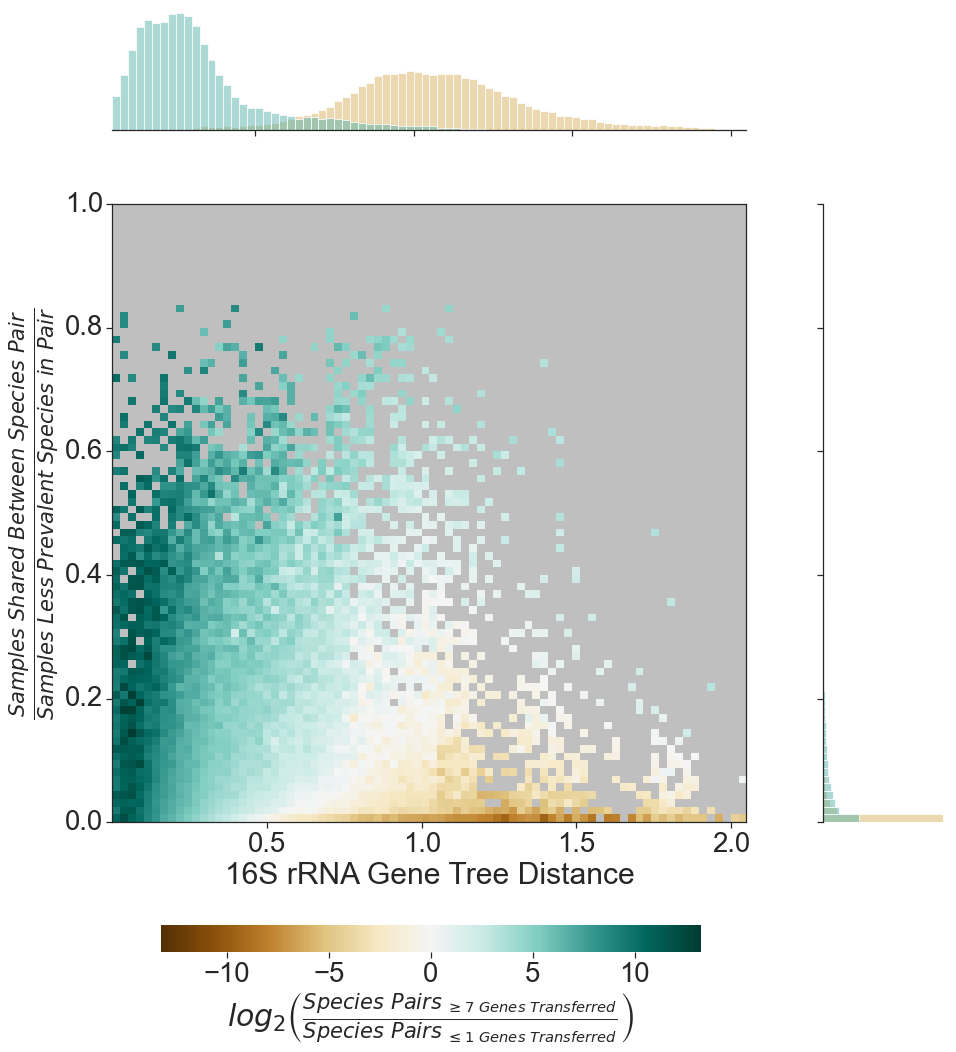

In [9]:
# We have way more OTU pairs with no or 1 transfers, so we randomly subsample pairs to
# compare distribution shapes directly.
sampled_few_genes_for_histogram = few_genes_exchanged.iloc[np.random.choice(len(few_genes_exchanged), len(many_genes_exchanged), replace = False), :]
multiplication_factor = len(few_genes_exchanged)/len(many_genes_exchanged)
combined_selection = pd.concat([many_genes_exchanged, sampled_few_genes_for_histogram]).reset_index()
combined_selection["type"] = ["Top 20%"] * len(many_genes_exchanged) + ["Bottom 20%"] * len(sampled_few_genes_for_histogram)

# For joint plot, need to calculate the ratio of transfer counts between the two populations.
histogram_many = np.histogram2d(x = many_genes_exchanged["distance"], y = many_genes_exchanged["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_many[0][histogram_many[0] == 0] = np.nan

histogram_few = np.histogram2d(x = few_genes_exchanged["distance"], y = few_genes_exchanged["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_few[0][histogram_few[0] == 0] = np.nan

ratio_many_few = np.log2((multiplication_factor * histogram_many[0]) / histogram_few[0])
total_observations = histogram_many[0] + histogram_few[0]  # to prevent large ratios, we only look at bins with at least 5 observations
ratio_many_few[total_observations < 5] = np.nan

ratio_many_few = np.transpose(ratio_many_few)
print(np.nanmin(ratio_many_few), np.nanmax(ratio_many_few))  # for plotting the same color bar

# Now, plotting all the results
plt.rcParams['svg.fonttype'] = 'none'
sns.set(font_scale = 2.5, style = "ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15), gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.17, 0.005, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = combined_selection, x = "distance", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [start_distance, end_distance], ax = axes[0,0], palette = ["#5ab4ac", "#d8b365"])


sns.heatmap(ratio_many_few, annot = False, cmap = "BrBG", ax = axes[1,0],
            vmin = -13.25, vmax = 13.25,
            center = 0, cbar_ax = cbar_ax,  cbar_kws={'label': r'$log_2\left(\frac{Species\ Pairs_{\ \geq7\ Genes\ Transferred}}{Species\ Pairs_{\ \leq1\ Genes\ Transferred}}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = combined_selection, y = "fraction_overlap", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [0, 1], ax = axes[1,1], palette = ["#5ab4ac", "#d8b365"])

axes[0,0].set(xlim = [start_distance, end_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [], xticks = [0.5, 1.0, 1.5, 2.0], xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("16S rRNA Gene Tree Distance")
axes[1,0].set_xticks([(0.5*bin_number)/end_distance, (bin_number)/end_distance, (1.5*bin_number)/end_distance, (2*bin_number)/end_distance])
axes[1,0].set_xticklabels(["0.5", "1.0", "1.5", "2.0"], rotation = 0)
axes[1,0].set_ylabel(r'$\frac{Samples\ Shared\ Between\ Species\ Pair}{Samples\ Less\ Prevalent\ Species\ in\ Pair}$')
axes[1,0].set_yticks([0, 0.2 * bin_number, 0.4 * bin_number, 0.6 * bin_number, 0.8 * bin_number, bin_number])
axes[1,0].set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = (0, 1), xlabel = "", ylabel = "", yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels = [], xticks = [], xticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

### Fixing phylogenetic distance distribution to see what happens with co-occurrence.

In [10]:
ref_bins = np.linspace(start_distance, end_distance, bin_number + 1)

sampled_many_genes_dist = pd.DataFrame()
sampled_few_genes_dist = pd.DataFrame()

for i in range(1, len(ref_bins)):
    sel_many_within_dist = many_genes_exchanged.loc[(many_genes_exchanged["distance"] > ref_bins[i-1]) & (many_genes_exchanged["distance"] <= ref_bins[i]), :] 
    sel_few_within_dist  = few_genes_exchanged.loc[(few_genes_exchanged["distance"] > ref_bins[i-1]) & (few_genes_exchanged["distance"] <= ref_bins[i]), :]
    
    if len(sel_few_within_dist) < len(sel_many_within_dist):
        many_to_add = sel_many_within_dist.iloc[np.random.choice(len(sel_many_within_dist), len(sel_few_within_dist), replace = False)]
        sampled_many_genes_dist = pd.concat([sampled_many_genes_dist, many_to_add])
        sampled_few_genes_dist = pd.concat([sampled_few_genes_dist, sel_few_within_dist])
    else:
        few_to_add = sel_few_within_dist.iloc[np.random.choice(len(sel_few_within_dist), len(sel_many_within_dist), replace = False)]
        sampled_few_genes_dist = pd.concat([sampled_few_genes_dist, few_to_add])
        sampled_many_genes_dist = pd.concat([sampled_many_genes_dist, sel_many_within_dist])

print(sampled_few_genes_dist.head())

                            otu97_1                      otu97_2  distance  \
131051     B16S;90_74;96_120;97_127   B16S;90_74;96_3495;97_4253    0.0724   
131544     B16S;90_74;96_120;97_127     B16S;90_74;96_233;97_253    0.0739   
191830   B16S;90_93;96_1360;97_1595   B16S;90_93;96_3157;97_3846    0.0664   
214429  B16S;90_816;96_2383;97_2854  B16S;90_816;96_2238;97_2676    0.0678   
252321   B16S;90_74;96_3495;97_4253   B16S;90_74;96_4379;97_5336    0.0723   

        genes_transferred  fraction_overlap  intersection  presence_1  \
131051                1.0          0.060000           3.0      1040.0   
131544                1.0          0.066884          41.0      1040.0   
191830                0.0          0.078431           4.0       270.0   
214429                0.0          0.254386          29.0      1779.0   
252321                1.0          0.020000           1.0        50.0   

        presence_2  minimum_overlap  
131051        50.0             50.0  
131544       613

-4.087462841250339 4.807354922057604


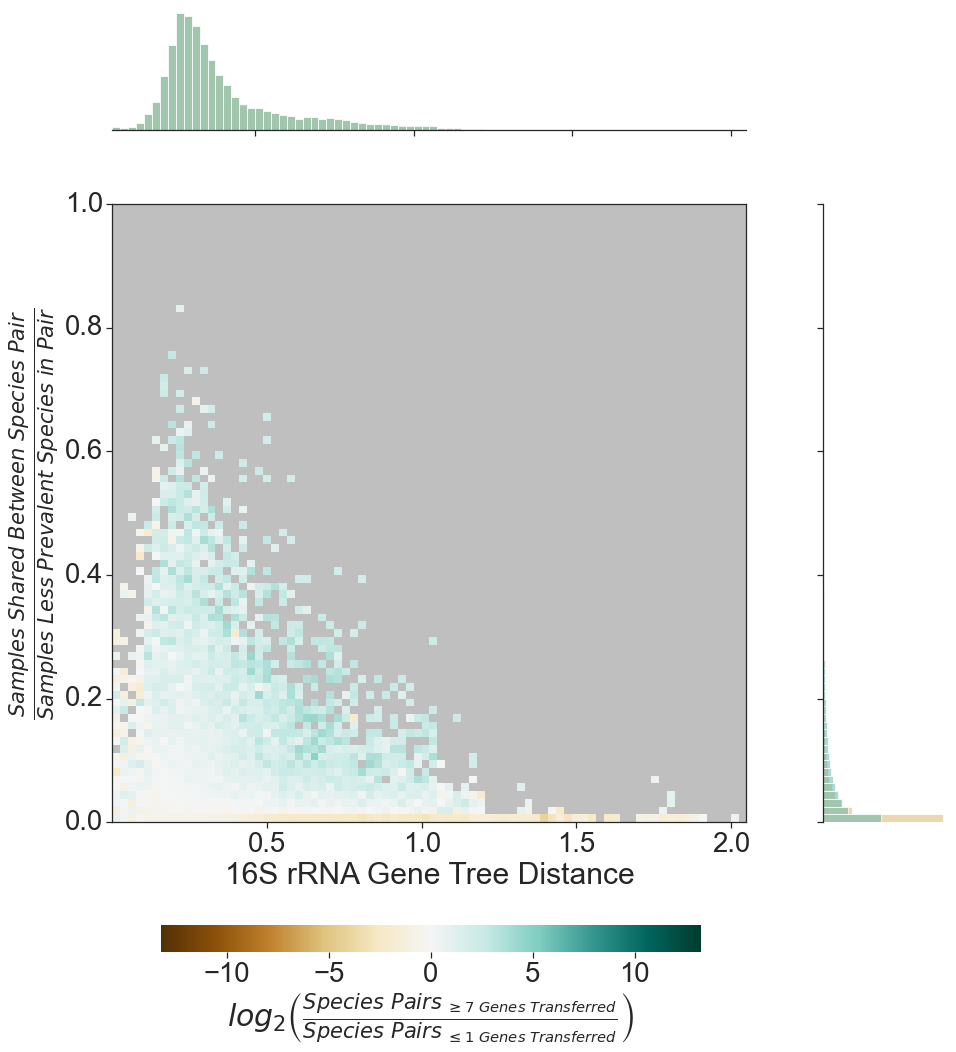

In [11]:
# For marginal histograms, need to combine data from the two populations.
combined_selection_dist = pd.concat([sampled_many_genes_dist, sampled_few_genes_dist]).reset_index()
combined_selection_dist["type"] = ["Top 20%"] * len(sampled_many_genes_dist) + ["Bottom 20%"] * len(sampled_few_genes_dist)

# For joint plot, need to calculate the ratio of transfer counts between the two populations.
histogram_many = np.histogram2d(x = sampled_many_genes_dist["distance"], y = sampled_many_genes_dist["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_few = np.histogram2d(x = sampled_few_genes_dist["distance"], y = sampled_few_genes_dist["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_many[0][histogram_many[0] == 0] = np.nan
histogram_few[0][histogram_few[0] == 0] = np.nan

ratio_many_few_dist = np.log2(histogram_many[0] / histogram_few[0])
total_observations = histogram_many[0] + histogram_few[0]
ratio_many_few_dist[total_observations < 5] = np.nan

ratio_many_few_dist = np.transpose(ratio_many_few_dist)
print(np.nanmin(ratio_many_few_dist), np.nanmax(ratio_many_few_dist))  # for plotting the same color bar

# Now, plotting all the results
plt.rcParams['svg.fonttype'] = 'none'
sns.set(font_scale = 2.5, style = "ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15), gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.17, 0.005, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = combined_selection_dist, x = "distance", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [start_distance, end_distance], ax = axes[0,0], palette = ["#5ab4ac", "#d8b365"])


sns.heatmap(ratio_many_few_dist, annot = False, cmap = "BrBG", ax = axes[1,0],
            vmin = -13.25, vmax = 13.25,
            center = 0, cbar_ax = cbar_ax, cbar_kws={'label': r'$log_2\left(\frac{Species\ Pairs_{\ \geq7\ Genes\ Transferred}}{Species\ Pairs_{\ \leq1\ Genes\ Transferred}}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = combined_selection_dist, y = "fraction_overlap", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [0, 1], ax = axes[1,1], palette = ["#5ab4ac", "#d8b365"])

axes[0,0].set(xlim = [start_distance, end_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [], xticks = [0.5, 1.0, 1.5, 2.0], xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("16S rRNA Gene Tree Distance")
axes[1,0].set_xticks([(0.5*bin_number)/end_distance, (bin_number)/end_distance, (1.5*bin_number)/end_distance, (2*bin_number)/end_distance])
axes[1,0].set_xticklabels(["0.5", "1.0", "1.5", "2.0"], rotation = 0)
axes[1,0].set_ylabel(r'$\frac{Samples\ Shared\ Between\ Species\ Pair}{Samples\ Less\ Prevalent\ Species\ in\ Pair}$')
axes[1,0].set_yticks([0, 0.2 * bin_number, 0.4 * bin_number, 0.6 * bin_number, 0.8 * bin_number, bin_number])
axes[1,0].set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = (0, 1), xlabel = "", ylabel = "", yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels = [], xticks = [], xticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

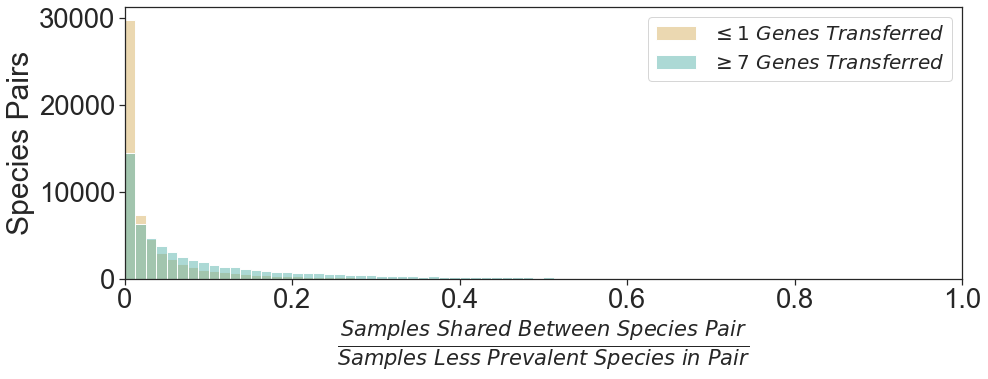

In [12]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = combined_selection_dist, x = "fraction_overlap", hue = "type", kde = False, axes = axes, legend = False, alpha = 0.5, bins = bin_number, binrange = [start_frac_overlap, end_frac_overlap], palette = ["#5ab4ac", "#d8b365"])
axes.set(xlabel = r'$\frac{Samples\ Shared\ Between\ Species\ Pair}{Samples\ Less\ Prevalent\ Species\ in\ Pair}$', xlim = [0, 1], xticks = [0, 0.2, 0.4, 0.6, 0.8, 1], ylabel = "Species Pairs")
axes.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"], rotation = 0)
plt.legend(labels = [r'$\leq1\ Genes\ Transferred$', r'$\geq7\ Genes\ Transferred$'], prop = {'size': 20})

In [13]:
mannwhitneyu(combined_selection_dist.loc[combined_selection_dist["type"] == "Top 20%", "fraction_overlap"], combined_selection_dist.loc[combined_selection_dist["type"] == "Bottom 20%", "fraction_overlap"])

MannwhitneyuResult(statistic=2276033105.5, pvalue=0.0)

### Fixing the co-occurrence and seeing what happens with the phylogenetic distance distribution.

In [14]:
ref_bins = np.linspace(start_frac_overlap, end_frac_overlap, bin_number + 1)

sampled_many_genes_frov = pd.DataFrame()
sampled_few_genes_frov = pd.DataFrame()

for i in range(1, len(ref_bins)):
    sel_many_within_fraction = many_genes_exchanged.loc[(many_genes_exchanged["fraction_overlap"] > ref_bins[i-1]) & (many_genes_exchanged["fraction_overlap"] <= ref_bins[i]), :] 
    sel_few_within_fraction  = few_genes_exchanged.loc[(few_genes_exchanged["fraction_overlap"] > ref_bins[i-1]) & (few_genes_exchanged["fraction_overlap"] <= ref_bins[i]), :]
    
    if len(sel_few_within_fraction) < len(sel_many_within_fraction):
        many_to_add = sel_many_within_fraction.iloc[np.random.choice(len(sel_many_within_fraction), len(sel_few_within_fraction), replace = False)]
        sampled_many_genes_frov = pd.concat([sampled_many_genes_frov, many_to_add])
        sampled_few_genes_frov = pd.concat([sampled_few_genes_frov, sel_few_within_fraction])
    else:
        few_to_add = sel_few_within_fraction.iloc[np.random.choice(len(sel_few_within_fraction), len(sel_many_within_fraction), replace = False)]
        sampled_few_genes_frov = pd.concat([sampled_few_genes_frov, few_to_add])
        sampled_many_genes_frov = pd.concat([sampled_many_genes_frov, sel_many_within_fraction])

print(sampled_few_genes_frov.head())

                              otu97_1                       otu97_2  distance  \
6063801      B16S;90_83;96_396;97_438  B16S;90_214;96_8816;97_20748    0.8250   
5283424  B16S;90_1979;96_5808;97_6993      B16S;90_88;96_704;97_814    1.0360   
7808493    B16S;90_31;96_2390;97_2862     B16S;90_6;96_2535;97_4837    1.5982   
556044      B16S;90_47;96_781;97_1420   B16S;90_553;96_2714;97_5380    0.8627   
7083298    B16S;90_63;96_1272;97_5030   B16S;90_237;96_3277;97_3989    0.9050   

         genes_transferred  fraction_overlap  intersection  presence_1  \
6063801                0.0          0.001477           4.0      2709.0   
5283424                0.0          0.004073           2.0     24891.0   
7808493                0.0          0.000812           1.0      1232.0   
556044                 0.0          0.000829           1.0      1207.0   
7083298                0.0          0.007519           6.0      5917.0   

         presence_2  minimum_overlap  
6063801      3669.0          

-7.383704292474052 9.46352437327118


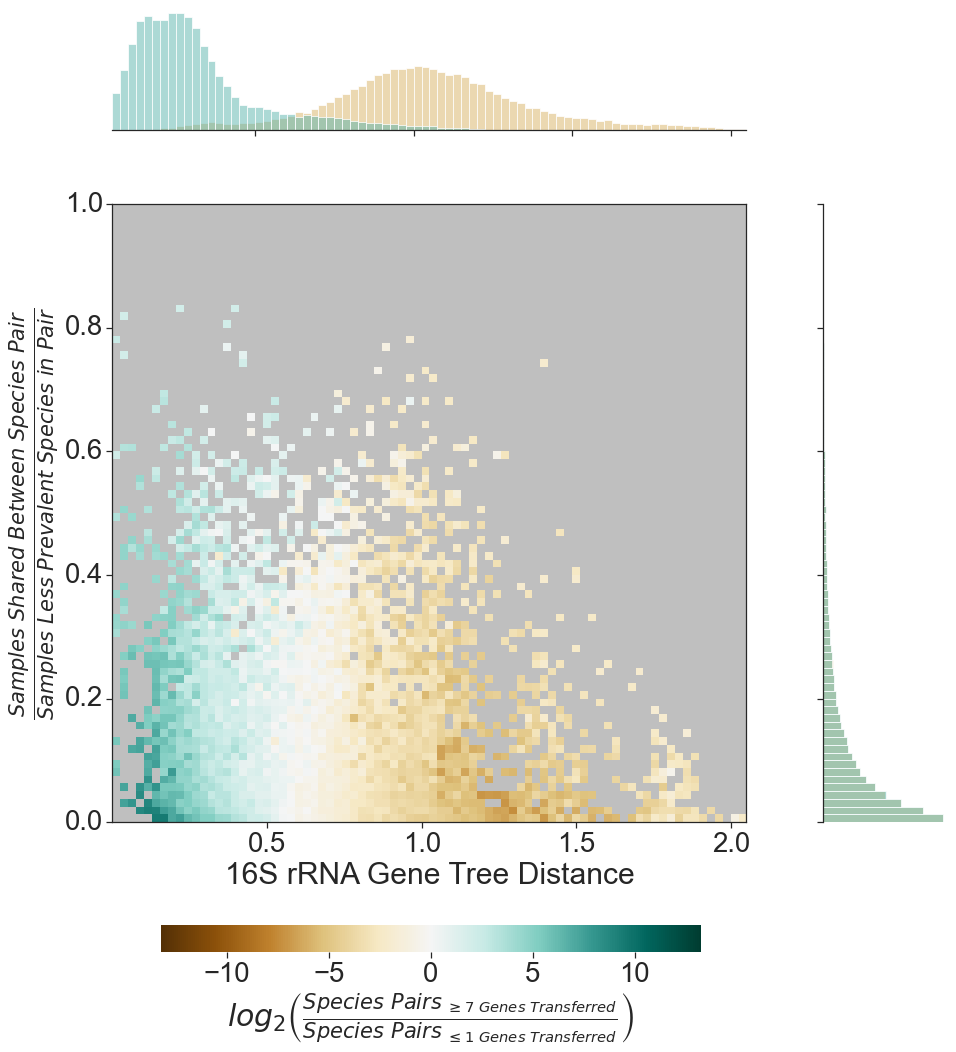

In [16]:
# For marginal histograms, need to combine data from transfers and reference
combined_selection_frov = pd.concat([sampled_many_genes_frov, sampled_few_genes_frov]).reset_index()
combined_selection_frov["type"] = ["Top 20%"] * len(sampled_many_genes_frov) + ["Bottom 20%"] * len(sampled_few_genes_frov)

# For joint plot, need to calculate the ratio of transfer counts between the two populations.
histogram_many = np.histogram2d(x = sampled_many_genes_frov["distance"], y = sampled_many_genes_frov["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_few = np.histogram2d(x = sampled_few_genes_frov["distance"], y = sampled_few_genes_frov["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_many[0][histogram_many[0] == 0] = np.nan
histogram_few[0][histogram_few[0] == 0] = np.nan

ratio_many_few_frov= np.log2(histogram_many[0] / histogram_few[0])
total_observations = histogram_many[0] + histogram_few[0]
ratio_many_few_frov[total_observations < 5] = np.nan

ratio_many_few_frov= np.transpose(ratio_many_few_frov)
print(np.nanmin(ratio_many_few_frov), np.nanmax(ratio_many_few_frov))  # for plotting the same color bar

# Now, plotting all the results
plt.rcParams['svg.fonttype'] = 'none'
sns.set(font_scale = 2.5, style = "ticks")
figures, axes = plt.subplots(2, 2, figsize = (15, 15), gridspec_kw = {"width_ratios": [5, 1], "height_ratios": [1, 5]})
cbar_ax = figures.add_axes([0.17, 0.005, 0.5, .025])

with sns.axes_style("white"):
    sns.histplot(data = combined_selection_frov, x = "distance", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [start_distance, end_distance], ax = axes[0,0], palette = ["#5ab4ac", "#d8b365"])


sns.heatmap(ratio_many_few_frov, annot = False, cmap = "BrBG", ax = axes[1,0],
            vmin = -13.25, vmax = 13.25,
            center = 0, cbar_ax = cbar_ax,  cbar_kws={'label': r'$log_2\left(\frac{Species\ Pairs_{\ \geq7\ Genes\ Transferred}}{Species\ Pairs_{\ \leq1\ Genes\ Transferred}}\right)$', 'orientation': 'horizontal'})

with sns.axes_style("white"):
    sns.histplot(data = combined_selection_frov, y = "fraction_overlap", hue = "type", kde = False, legend = False, alpha = 0.5, bins = bin_number, binrange = [0, 1], ax = axes[1,1], palette = ["#5ab4ac", "#d8b365"])

axes[0,0].set(xlim = [start_distance, end_distance], xlabel = "", ylabel = "", yticks = [], yticklabels = [], xticks = [0.5, 1.0, 1.5, 2.0], xticklabels = [])
sns.despine(ax = axes[0,0], left = True, top = True, right = True, bottom = False)

axes[0,1].axis('off')

axes[1,0].invert_yaxis()
axes[1,0].set_xlabel("16S rRNA Gene Tree Distance")
axes[1,0].set_xticks([(0.5*bin_number)/end_distance, (bin_number)/end_distance, (1.5*bin_number)/end_distance, (2*bin_number)/end_distance])
axes[1,0].set_xticklabels(["0.5", "1.0", "1.5", "2.0"], rotation = 0)
axes[1,0].set_ylabel(r'$\frac{Samples\ Shared\ Between\ Species\ Pair}{Samples\ Less\ Prevalent\ Species\ in\ Pair}$')
axes[1,0].set_yticks([0, 0.2 * bin_number, 0.4 * bin_number, 0.6 * bin_number, 0.8 * bin_number, bin_number])
axes[1,0].set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], rotation = 0)
axes[1,0].set_facecolor("#bfbfbf")
for _, spine in axes[1,0].spines.items():
    spine.set_visible(True)

axes[1,1].set(ylim = (0, 1), xlabel = "", ylabel = "", yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels = [], xticks = [], xticklabels = [])
sns.despine(ax = axes[1,1], left = False, top = True, right = True, bottom = True)

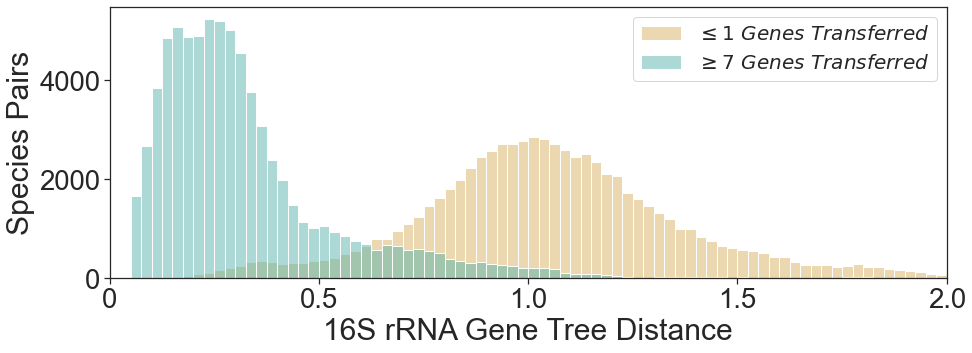

In [17]:
figures, axes = plt.subplots(1, 1, figsize = (15, 5))
sns.histplot(data = combined_selection_frov, x = "distance", hue = "type", kde = False, axes = axes, legend = False, alpha = 0.5, bins = bin_number, binrange = [start_distance, end_distance], palette = ["#5ab4ac", "#d8b365"])
axes.set(xlabel = "16S rRNA Gene Tree Distance", xlim = [0, 2], xticks = [0, 0.5, 1.0, 1.5, 2.0], ylabel = "Species Pairs")
axes.set_xticklabels(["0", "0.5", "1.0", "1.5", "2.0"], rotation = 0)
plt.legend(labels = [r'$\leq1\ Genes\ Transferred$', r'$\geq7\ Genes\ Transferred$'], prop = {'size': 20})

In [18]:
mannwhitneyu(combined_selection_frov.loc[combined_selection_frov["type"] == "Top 20%", "distance"], combined_selection_frov.loc[combined_selection_frov["type"] == "Bottom 20%", "distance"])

MannwhitneyuResult(statistic=221677391.5, pvalue=0.0)

# Comparing HGT in interacting and non-interacting species.

Determining whether species that interact exchange more genes than species that only co-occur.

In [19]:
# Need to generate a 2D histogram of phylogenetic distance and co-occurrence to account for these factors
histogram_many = np.histogram2d(x = many_genes_exchanged["distance"], y = many_genes_exchanged["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_many[0][histogram_many[0] == 0] = np.nan
histogram_few = np.histogram2d(x = few_genes_exchanged["distance"], y = few_genes_exchanged["fraction_overlap"], bins = bin_number, range = [[start_distance, end_distance], [start_frac_overlap, end_frac_overlap]])
histogram_few[0][histogram_few[0] == 0] = np.nan

high_exchange_selected = pd.DataFrame()
low_exchange_selected = pd.DataFrame()

for x in range(1, bin_number + 1):
    for y in range(1, bin_number + 1):
        
        high_exchange_within_bin = many_genes_exchanged.loc[(many_genes_exchanged["distance"] >= histogram_many[1][x-1]) & (many_genes_exchanged["distance"] < histogram_many[1][x]), :] 
        high_exchange_within_bin = high_exchange_within_bin.loc[(high_exchange_within_bin["fraction_overlap"] >= histogram_many[2][y-1]) & (high_exchange_within_bin["fraction_overlap"] < histogram_many[2][y]), :]     
        
        low_exchange_within_bin = few_genes_exchanged.loc[(few_genes_exchanged["distance"] >= histogram_few[1][x-1]) & (few_genes_exchanged["distance"] < histogram_few[1][x]), :] 
        low_exchange_within_bin = low_exchange_within_bin.loc[(low_exchange_within_bin["fraction_overlap"] >= histogram_few[2][y-1]) & (low_exchange_within_bin["fraction_overlap"] < histogram_few[2][y]), :]     
        
        if len(high_exchange_within_bin) > len(low_exchange_within_bin):

            high_exchange_rows_to_add = high_exchange_within_bin.iloc[np.random.choice(len(high_exchange_within_bin), len(low_exchange_within_bin), replace = False)]
            high_exchange_selected = pd.concat([high_exchange_selected, high_exchange_rows_to_add])
            low_exchange_selected = pd.concat([low_exchange_selected, low_exchange_within_bin])
            
        else:

            low_exchange_rows_to_add = low_exchange_within_bin.iloc[np.random.choice(len(low_exchange_within_bin), len(high_exchange_within_bin), replace = False)]
            low_exchange_selected = pd.concat([low_exchange_selected, low_exchange_rows_to_add])
            high_exchange_selected = pd.concat([high_exchange_selected, high_exchange_within_bin])

print(high_exchange_selected.shape)
print(low_exchange_selected.shape)

(55451, 9)
(55451, 9)


In [21]:
combined_selection_for_interactions = pd.concat([high_exchange_selected, low_exchange_selected]).reset_index()
combined_selection_for_interactions["type"] = ["Top 20%"] * len(high_exchange_selected) + ["Bottom 20%"] * len(low_exchange_selected)

# For mapping to interaction network, need to use short OTU names.
combined_selection_for_interactions["otu97_1_short"] = combined_selection_for_interactions["otu97_1"].apply(lambda x: x[0] + x.split(";")[-1])
combined_selection_for_interactions["otu97_2_short"] = combined_selection_for_interactions["otu97_2"].apply(lambda x: x[0] + x.split(";")[-1])
combined_selection_for_interactions

,index,otu97_1,otu97_2,distance,genes_transferred,fraction_overlap,intersection,presence_1,presence_2,minimum_overlap,type,otu97_1_short,otu97_2_short
0,7105893,B16S;90_14;96_266;97_3572,B16S;90_14;96_266;97_3870,0.0702,115.0,0.000000,0.0,217.0,21.0,21.0,Top 20%,B97_3572,B97_3870
1,8312256,B16S;90_170;96_2832;97_3427,B16S;90_170;96_2054;97_2455,0.0690,45.0,0.000000,0.0,343.0,80.0,80.0,Top 20%,B97_3427,B97_2455
2,3263289,B16S;90_3;96_2699;97_3258,B16S;90_3;96_13157;97_25804,0.0655,7.0,0.000000,0.0,39.0,24.0,24.0,Top 20%,B97_3258,B97_25804
3,5639785,B16S;90_149;96_3312;97_4035,B16S;90_19;96_110;97_351,0.0615,29.0,0.000000,0.0,23.0,1512.0,23.0,Top 20%,B97_4035,B97_351
4,7199267,B16S;90_14;96_17;97_1731,B16S;90_14;96_4234;97_5151,0.0738,55.0,0.008547,2.0,234.0,1358.0,234.0,Top 20%,B97_1731,B97_5151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110897,1235070,B16S;90_26551;96_1403;97_3187,B16S;90_30876;96_1958;97_2334,2.0199,0.0,0.000506,1.0,1978.0,13353.0,1978.0,Bottom 20%,B97_3187,B97_2334
110898,1466531,B16S;90_30427;96_2723;97_3287,B16S;90_857;96_2372;97_2841,2.0165,0.0,0.002341,9.0,3934.0,3844.0,3844.0,Bottom 20%,B97_3287,B97_2841
110899,6750129,B16S;90_344;96_7348;97_8796,B16S;90_26574;96_936;97_1087,2.0397,0.0,0.001636,19.0,12858.0,11612.0,11612.0,Bottom 20%,B97_8796,B97_1087
110900,3759404,B16S;90_251;96_536;97_607,B16S;90_904;96_2515;97_3022,2.0493,1.0,0.000000,0.0,1945.0,1474.0,1474.0,Bottom 20%,B97_607,B97_3022


In [70]:
global_interaction_network_1 = pd.read_csv("/mnt/mnemo6/janko/projects/global_interactions/results/net_minz_full_cond.edgelist", \
                                         sep = "\t", skiprows = 2, header = None)
global_interaction_network_1.columns = ["otu97_1", "otu97_2", "score"]
global_interaction_network_2 = global_interaction_network_1.loc[ :, ["otu97_2", "otu97_1", "score"]]
global_interaction_network_2.columns = global_interaction_network_1.columns
global_interaction_network = pd.concat([global_interaction_network_1, global_interaction_network_2]).reset_index().loc[:, ["otu97_1", "otu97_2", "score"]]

In [72]:
# Mapping interaction scores from global network to OTUs.
interaction_scores = global_interaction_network["score"]
interaction_scores.index = global_interaction_network["otu97_1"] + " " + global_interaction_network["otu97_2"]
combined_selection_for_interactions["interaction_score"] = (combined_selection_for_interactions["otu97_1_short"] + " " + combined_selection_for_interactions["otu97_2_short"]).map(interaction_scores)
print(sum(combined_selection_for_interactions["interaction_score"] < 0), sum(combined_selection_for_interactions["interaction_score"] > 0))

50 1533


In [73]:
combined_selection_for_interactions.loc[~(combined_selection_for_interactions["interaction_score"].isna()), "type"].value_counts()

Top 20%       1012
Bottom 20%     571
Name: type, dtype: int64

### Using interactions predicted with no confounding signal correction

In [78]:
# Uploading global network that has not been corrected for confounding signals.
global_uncorrected_network_1 = pd.read_csv("/mnt/mnemo6/janko/projects/global_interactions/results/net_minz_full_uni.edgelist", \
                                         sep = "\t", skiprows = 2, header = None)
global_uncorrected_network_1.columns = ["otu97_1", "otu97_2", "score"]
global_uncorrected_network_2 = global_uncorrected_network_1.loc[ :, ["otu97_2", "otu97_1", "score"]]
global_uncorrected_network_2.columns = global_uncorrected_network_1.columns
global_uncorrected_network = pd.concat([global_uncorrected_network_1, global_uncorrected_network_2]).reset_index().loc[:, ["otu97_1", "otu97_2", "score"]]

In [80]:
# Mapping interaction scores from global network to OTUs.
global_univariate_network["otu97_1"].isin(pd.concat([combined_selection_for_interactions["otu97_1_short"], combined_selection_for_interactions["otu97_2_short"]]))
univariate_scores = global_univariate_network["score"]
univariate_scores.index = global_univariate_network["otu97_1"] + " " + global_univariate_network["otu97_2"]
combined_selection_for_interactions["univariate_score"] = (combined_selection_for_interactions["otu97_1_short"] + " " + combined_selection_for_interactions["otu97_2_short"]).map(univariate_scores)
print(sum(combined_selection_for_interactions["univariate_score"] < 0), sum(combined_selection_for_interactions["univariate_score"] > 0))

4458 18138


In [81]:
combined_selection_for_interactions.loc[~(combined_selection_for_interactions["univariate_score"].isna()), "type"].value_counts()

Top 20%       12525
Bottom 20%    10071
Name: type, dtype: int64